In [1]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

url = urlopen("https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify")
soup = BeautifulSoup(url)

In [2]:
s_songs = pd.read_csv("data.csv")
s_songs[s_songs["id"] == "2xLMifQCjDGFmkHkpNLD9h"]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo


In [3]:
table = soup.find_all("table")[0]

In [4]:
table

<table class="wikitable sortable">
<tbody><tr>
<th>Rank
</th>
<th>Song
</th>
<th>Artist(s)
</th>
<th>Album
</th>
<th>Streams<br/>(Millions)
</th>
<th>Date published
</th></tr>
<tr>
<th align="center">1
</th>
<td>"<a href="/wiki/Shape_of_You" title="Shape of You">Shape of You</a>"</td>
<td><a href="/wiki/Ed_Sheeran" title="Ed Sheeran">Ed Sheeran</a></td>
<td><i><a href="/wiki/%C3%B7_(album)" title="÷ (album)">÷</a></i></td>
<td align="center">2,654</td>
<td align="right">6 January 2017
</td></tr>
<tr>
<th align="center">2
</th>
<td>"<a href="/wiki/Rockstar_(Post_Malone_song)" title="Rockstar (Post Malone song)">Rockstar</a>"</td>
<td><a href="/wiki/Post_Malone" title="Post Malone">Post Malone</a> featuring <a href="/wiki/21_Savage" title="21 Savage">21 Savage</a></td>
<td><i><a href="/wiki/Beerbongs_%26_Bentleys" title="Beerbongs &amp; Bentleys">Beerbongs &amp; Bentleys</a></i></td>
<td align="center">2,064</td>
<td align="right"><span class="nowrap">15 September 2017</span>
</td></tr>


In [5]:
headers = [header.get_text()[0:-1] for header in table.find_all("th")[0:6]]

In [6]:
from datetime import datetime

df = pd.DataFrame(columns=headers)
rows = table.find("tbody").find_all("tr")[1:]

for row in rows[0:-1]:
    song = {headers[0]:row.find("th").get_text()[:-1]}
    params = [param.get_text() for param in row.find_all("td")]
    
    song[headers[1]] = params[0][1:-1]
    artists = params[1].strip()
    artists = artists.split(" featuring ")
    artists = np.array([x.split(", ") for x in artists]).flatten()
    artists = [str(x) for x in artists]
    artists = np.array([x.split(" and ") for x in artists]).flatten()
    artists = [str(x) for x in artists]
    artists = [x.replace("]","") for x in artists]
    artists = [x.replace("[","") for x in artists]
    artists = [x.replace("'","") for x in artists]
    if(artists[0] == "Tones"):
        artists = np.array(["Tones and I"])
    song[headers[2]] = artists
    song[headers[3]] = params[2]
    song[headers[4]] = int(params[3].replace(",",""))
    date = datetime.strptime(params[4][0:-1],"%d %B %Y")
    song[headers[5]] = date
    
    df = df.append(song,ignore_index=True)

df = df.set_index("Rank")

In [7]:
fix_dict = {"Rockstar":"rockstar (feat. 21 Savage)",
            "Sunflower":"Sunflower - Spider-Man: Into the Spider-Verse",
            "Thinking Out Loud":"Thinking out Loud",
            "Bad Guy":"bad guy",
            "Havana":"Havana (feat. Young Thug)",
            "Despacito (Remix)":"Despacito - Remix",
            "Humble":"HUMBLE.",
            "Sad!":"SAD!",
            "I Took a Pill in Ibiza (Seeb Remix)":"I Took A Pill In Ibiza - Seeb Remix",
            "7 Rings":"7 rings",
            "Sicko Mode":"SICKO MODE",
            "Take Me To Church":"Take Me to Church",
            "Stay with Me":"Stay With Me",
            "Goosebumps":"goosebumps",
            "Uptown Funk":"Uptown Funk (feat. Bruno Mars)",
            "Thank U, Next":"thank u, next",
            "Lovely":"lovely (with Khalid)",
            "I Don't Care":"I Don't Care (with Justin Bieber)",
            "Too Good at Goodbyes":"Too Good At Goodbyes",
            "Can't Hold Us":"Can't Hold Us - feat. Ray Dalton",
            "Psycho":"Psycho (feat. Ty Dolla $ign)",
            "See You Again":"See You Again (feat. Charlie Puth)",
            "One Kiss":"One Kiss (with Dua Lipa)",
            "Cheerleader (Felix Jaehn Remix)":"Cheerleader - Felix Jaehn Remix Radio Edit",
            "Eastside":"Eastside (with Halsey & Khalid)",
            "Old Town Road (Remix)":"Old Town Road - Remix",
            "This Is What You Came For":"This Is What You Came For (feat. Rihanna)",
            "Taki Taki":"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",
            "We Don't Talk Anymore":"We Don't Talk Anymore (feat. Selena Gomez)",
            "Work from Home":"Work from Home (feat. Ty Dolla $ign)",
            "I Don't Wanna Live Forever":"I Don’t Wanna Live Forever (Fifty Shades Darker)",
            "Roses (Imanbek Remix)":"Roses - Imanbek Remix"}

def fix_song(song_name):
    if(song_name in fix_dict):
        return fix_dict[song_name]
    else:
        return song_name

def find_song(song_name):
    return s_songs[s_songs["name"] == song_name]["popularity"].max()
    

df["Song"] = df["Song"].map(fix_song)
df["Popularity"] = df["Song"].map(find_song)
df = df.dropna()

In [11]:
df.to_csv("top100streams.csv")

Text(0, 0.5, 'Popularity')

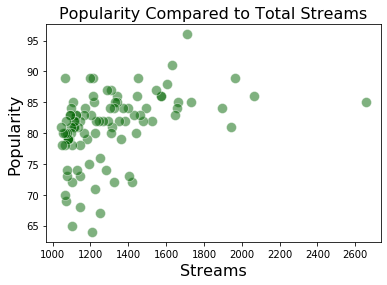

In [29]:
import seaborn as sns

df["LogStreams"] = np.log(df["Streams(Millions)"])

# create and display the scatter plot
graph = sns.scatterplot(x="Streams(Millions)", y="Popularity", data = df[df["Date published"] > datetime(2010,1,1)], 
                        marker = "o", s=100, color = "darkgreen", alpha=0.5)

#specify the title
title = "Popularity Compared to Total Streams"

#set the title of the plot
graph.set_title(title, size = 16)

#add labels to the axes  
graph.set_xlabel("Streams", size = 16)
graph.set_ylabel("Popularity", size = 16)

In [36]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

model = KNeighborsRegressor()

df["Date From 2010"] = df["Date published"] - datetime(2010,1,1)
df["Date From 2010"] = [int(str(da)[0:4]) for da in df["Date From 2010"]]
df["Streams(Millions)"] = [int(da) for da in df["Streams(Millions)"]]

df.dropna()
features = df[["Streams(Millions)","Date From 2010"]]
target = df["Popularity"]

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)
model = KNeighborsRegressor(n_neighbors = 5).fit(X=X_train, y=y_train)

model.fit(X = X_train, y=y_train)

print("R-squared value for training set: ", r2_score(y_train, model.predict(X_train)))
print("R-squared value for testing set: ", r2_score(y_test, model.predict(X_test)))

R-squared value for training set:  0.4468611720343223
R-squared value for testing set:  0.11646564125262804


In [28]:
model.score(features,target)

0.3564564027115106